# Classification usign Frame-Level Features
Here we try to classify songs to their respective artist using a two step procedure that consist in classifying frames to artists using standard classifiers (like KNN, SVM ecc.) and then classifying songs to to the artist for which the majority of its frame were classified in the previous step (this is far from the state-of-art but it's something we haven't found online so, though simple, is our own idea).

In [24]:
#load libraries
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.discriminant_analysis
import librosa.display
import numpy
import random
import pandas
import seaborn
import json

### Load Features
After the extraction of the features using the code provided in **Feature_Extraction.ipynb** we can simply load them from the .txt files (this will save time since feature extration can take a while).

In [25]:
with open('x.txt', 'r') as filehandle:
    y = json.load(filehandle)
with open('SR.txt', 'r') as filehandle:
    SR = json.load(filehandle)
with open('MFCC.txt', 'r') as filehandle:
    MFCC = json.load(filehandle)

In [26]:
##convert mfccs from list to numpy array that are faster to work with
x={}
for sr in SR:
    x[sr]={}
    for n_mfcc in MFCC:
        x[sr][n_mfcc]=[]
            
for sr in y:
    for n_mfcc in y[sr]:
        for t in y[sr][n_mfcc]:
            x[int(sr)][int(n_mfcc)].append({"artist": t["artist"],
                                            "song": t["song"],
                                            "mfcc":numpy.asarray(t["mfcc"])})

### Create a Balanced Train-Test split
Now we create a random, but balanced, train-test split, meaning that we control randomness in a way to use for training the model the same number of songs per artist (around 3/4 for train and 1/4 for test)

In [27]:
#create list of artists
artistlist=[]
for t in x[SR[0]][MFCC[0]]:
    if t["artist"] not in artistlist:
        artistlist.append(t["artist"])
artistlist.sort()
#print(artistlist)


#count number of songs for each artist
songcount={}
for t in x[SR[0]][MFCC[0]]:
    if t["artist"] not in songcount:
        songcount[t["artist"]] = 1
    else:
        songcount[t["artist"]]+=1
#print(songcount)


#find number of songs for the artist having the smallest number of songs
artist_with_min = min(songcount.keys(), key=(lambda k: songcount[k]))
min_song=songcount[artist_with_min]


#number of song per artist to use as train
N=int(min_song*3/4)
#print(N)


#Create a list of songs per each artist
songs={}
for t in x[SR[0]][MFCC[0]]:
    if t["artist"] not in songs:
        songs[t["artist"]]=[]
    songs[t["artist"]].append(t["song"])
#print(songs)

###create split
split={}
for artist in artistlist:
    split[artist]={}
    split[artist]["train"],split[artist]["test"]=sklearn.model_selection.train_test_split(songs[artist]
                                                                                          ,train_size=N
                                                                                          ,random_state=1)
songtrain=[]
songtest=[]
for artist in artistlist:
    songtrain = songtrain + split[artist]["train"]
    songtest = songtest + split[artist]["test"]
                     

#print(songtrain)
#print(songtest)

# Two step classification of songs to their artists using KNN:
Now as claimed we performe the two step classification

In [28]:
##num of neighbours, default is 5
k=10 
#initialize knn object
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean')

####SR=[2500]    to test
####MFCC=[4]     to test


#initialize CM, this will store the confusion matrices of all models
CM={}
for sr in SR:
    CM[sr]={}
    for n_mfcc in MFCC:
        CM[sr][n_mfcc]=0

#loop over samplig rates and number of mfcc
for sr in SR:
    for n_mfcc in MFCC:
        #print((sr,n_mfcc))
        
        #create a big matrix containing all mfcc of all songs of all artists for train and test
        features_train=numpy.empty((1,n_mfcc))
        features_test=numpy.empty((1,n_mfcc))
        for t in x[sr][n_mfcc]:
            if t["song"] in songtrain:
                features_train=numpy.vstack((features_train, t["mfcc"]))
            else:
                features_test=numpy.vstack((features_test, t["mfcc"]))
        features_train=numpy.delete(features_train,0,0)
        features_test=numpy.delete(features_test,0,0)
        
        #creating labels of each frame relative to the artist and to the song
        artist_labels_train=[]
        artist_labels_test=[]
        song_labels_train=[]
        song_labels_test=[]
        for t in x[sr][n_mfcc]:
            if t["song"] in songtrain:
                for _ in range(t["mfcc"].shape[0]):
                    artist_labels_train.append(t["artist"])
                    song_labels_train.append(t["song"])
            else:
                for _ in range(t["mfcc"].shape[0]):
                    artist_labels_test.append(t["artist"])
                    song_labels_test.append(t["song"])
        
        #train and test knn:this is the first step of the classification
        knn.fit(features_train, artist_labels_train)
        artist_pred_knn = knn.predict(features_test)
        
        #assing song to artist for which majority of its frame where calssified
        out_knn={}
        for song in songtest:
            u=[artist_pred_knn[u] for u in range(len(artist_pred_knn)) if song_labels_test[u] == song]
            out_knn[song]=max(set(u), key=u.count)
         
        
        #initialize confusion matrix
        N_art=len(artistlist)
        conf_matrix_knn = pandas.DataFrame(numpy.zeros(shape=(N_art,N_art)), columns = artistlist, index=artistlist)
        
        ##create dictionary such that to each artist correspond the list of its real songs
        song_and_artist_test={}
        for t in x[sr][n_mfcc]:
            if t["artist"] not in song_and_artist_test:
                song_and_artist_test[t["artist"]] = []
            if t["song"] in songtest:
                song_and_artist_test[t["artist"]].append(t["song"])
        
        
        ##create dictioary such that to each artist correspond the list of
        ##its songs as preddicted by knn two step procedure
        song_and_artist_pred_knn={}
        for key,value in out_knn.items():
            if value not in song_and_artist_pred_knn:
                song_and_artist_pred_knn[value] = []
            song_and_artist_pred_knn[value].append(key)  
        
        ##place in position (i,j) the number of songs from artist i predicted as of artist j
        for artist_t, listsong_t in song_and_artist_test.items():
            for artist_p, listsong_p in song_and_artist_pred_knn.items():
                tot=len(set(listsong_t).intersection(listsong_p))
                conf_matrix_knn[artist_p][artist_t]=tot
        
        #store confusion matrix
        CM[sr][n_mfcc]=conf_matrix_knn

        

# Performances Evaluation
Now we use all the confusion matrices stored in **CM** to evaluate performances. To this end we calculate class specific *precison* and *recall* and then we will average the values. This *macro*-averaged measures are suitable for assessing performaces of our models because every class has almost the same number of observations. For situations in which a significative differnce is present is better to use *micro*-averaged measures. Moreover we will also evaluate F1 score.

In [29]:
#inizialize PREC_REC
PREC_REC={}
for sr in SR:
    PREC_REC[sr]={}
    for n_mfcc in MFCC:
        PREC_REC[sr][n_mfcc]=0

#calculate precison and recall
for sr in SR:
    for n_mfcc in MFCC:
        cm=numpy.asarray(CM[sr][n_mfcc])
        recall = numpy.mean(numpy.diag(cm) / numpy.sum(cm, axis = 1))
        precision = numpy.mean(numpy.diag(cm) / numpy.sum(cm, axis = 0))
        F1 = (2*precision*recall)/(precision+recall)
        PREC_REC[sr][n_mfcc]={"recall":round(recall,3),"precision":round(precision,3),"F1":round(F1,3)}
        

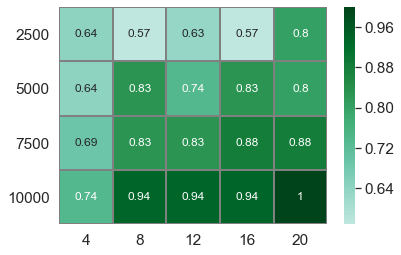

In [58]:
#visualization of F1 index
F1 = pandas.DataFrame(numpy.zeros(shape=(len(SR),len(MFCC))), columns = MFCC, index=SR)
for sr in SR:
    for n_mfcc in MFCC:
        F1[n_mfcc][sr]=PREC_REC[sr][n_mfcc]["F1"]

#nice heatmap
seaborn.set(font_scale=1.4)
seaborn.heatmap(F1, annot=True,annot_kws={"size": 12}
                  ,linewidths = 1,linecolor="gray",cmap="BuGn",center=0.7)
plt.yticks(rotation=0, horizontalalignment='right')
plt.show()